In [1]:
using Revise # Run this first, if you intend to develop the package

In [2]:
# unnecessary if you follow README
# using Pkg
# Pkg.activate("../QControl")
# Pkg.instantiate()

# Imports

In [3]:
using QControl

In [4]:
const QC = QControl;

In [5]:
using QuantumOptics
using PyPlot
using Altro
using ForwardDiff
using LinearAlgebra
using SparseArrays
using RobotDynamics
using TrajectoryOptimization
using StaticArrays
using ForwardDiff
using FiniteDiff
const TO = TrajectoryOptimization
const RD = RobotDynamics
;

In [6]:
# using PyCall;
# only needed once
# using Conda;
# Conda.add("qutip");
# Conda.add("imageio");

# Set up Dynamics

In [7]:
bq_single = SpinBasis(1//2)
H₀_single = 2*π*5*sigmaz(bq_single)/2
Hcs_single = [sigmax(bq_single)/2]
ψi_single = [spinup(bq_single)]
ψt_single = [spindown(bq_single)]
;

In [8]:
RD.state_dim(::QC.QuantumState), RD.control_dim(::QC.QuantumState), dynamics_func, astate_initial, astate_target = QC.gen_LQR_params(bq_single, H₀_single, Hcs_single, ψi_single, ψt_single)
RD.dynamics(qs::QC.QuantumState,x,u) = dynamics_func(qs::QC.QuantumState,x,u)
;

In [68]:
1/((3/1000)/9)

3000.0

In [79]:
model = QC.QuantumState();
state_dim = RD.state_dim(model)
control_dim = RD.control_dim(model)

N = 3001 # number of time steps
tf = 9.0 # ns, total time
dt = tf / (N-1) # time step
amp_scale = 0.0001/3
;

In [80]:
Q, R = gen_default_QR(state_dim, control_dim; N=N, tf=tf, amp_scale=amp_scale)
Q

10×10 Diagonal{Float64, Vector{Float64}}:
 0.0   ⋅    ⋅    ⋅    ⋅           ⋅          …   ⋅            ⋅ 
  ⋅   0.0   ⋅    ⋅    ⋅           ⋅              ⋅            ⋅ 
  ⋅    ⋅   0.0   ⋅    ⋅           ⋅              ⋅            ⋅ 
  ⋅    ⋅    ⋅   0.0   ⋅           ⋅              ⋅            ⋅ 
  ⋅    ⋅    ⋅    ⋅   3.33333e-5   ⋅              ⋅            ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅          3.33333e-5  …   ⋅            ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅           ⋅              ⋅            ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅           ⋅              ⋅            ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅           ⋅             0.000333333   ⋅ 
  ⋅    ⋅    ⋅    ⋅    ⋅           ⋅              ⋅           0.000333333

In [81]:
obj = gen_default_objective(state_dim, control_dim, astate_target; N=N, tf=tf, amp_scale=amp_scale)

Objective

In [82]:
# Add in normalization constraint and goal constraint
cons = ConstraintList(state_dim, control_dim, N)
# normcon = NormConstraint(state_dim, control_dim, 1.0, Equality(), :state)
# add_constraint!(cons, normcon, N)


# normcon = NormConstraint(state_dim, control_dim, π/3*2, Equality(), :control)
# add_constraint!(cons, normcon, N)

goalcon = GoalConstraint(astate_target)
add_constraint!(cons, goalcon, N)

In [83]:
prob = Problem(model, obj, astate_initial, tf, xf=astate_target, integration=RD.RK4(model), constraints=cons);

In [84]:
initial_controls!(prob, [@SVector rand(control_dim) for k = 1:N-1])
rollout!(prob)   # simulate the system forward in time with the new controls

In [85]:
# Set up solver options
opts = SolverOptions()
opts.cost_tolerance = 1e-8

# Create a solver, adding in additional options
solver = ALTROSolver(prob, opts, show_summary=false);

In [86]:
solve!(solver);

┌ Warning: A not upper triangular. Creating a new upper-triangular matrix.
└ @ Altro.Cqdldl /Users/phionx/.julia/packages/Altro/jipqO/src/qdldl.jl:156


In [87]:
status(solver)

SOLVE_SUCCEEDED::TerminationStatus = 2

In [88]:
println("Number of iterations: ", iterations(solver))
println("Final cost: ", cost(solver))
println("Final constraint satisfaction: ", max_violation(solver)) #TODO: is 1 good??

Number of iterations: 603
Final cost: 283.9969029340712
Final constraint satisfaction: 3.86866441659528e-11


# Save Data

In [89]:
# save data (uncomment to save)
save_solver_data(solver, label="data/pi_pulse_0_to_1_data")

In [90]:
# load data
data = load_solver_data("data/pi_pulse_0_to_1_data.jld2")

Dict{String, Vector} with 2 entries:
  "acontrols" => SVector{2, Float64}[[3.29409, 37.1429], [-0.452359, 36.4771], …
  "astates"   => SVector{10, Float64}[[1.0, 5.71987e-13, -1.25196e-15, 5.68434e…

# Parse Data

In [91]:
astates = data["astates"]
acontrols = data["acontrols"]
Xqv = states_to_kets(map(astate -> astate[1:4], astates), bq_single)
iUcv = controls_to_amplitudes(map(astate -> astate[5:6], astates))
Ucv = controls_to_amplitudes(map(astate -> astate[7:8], astates))
dUcv = controls_to_amplitudes(map(astate -> astate[9:10], astates))
ddUcv = controls_to_amplitudes(acontrols)
ts = dt*(1:N)
;

# Analyze States

In [92]:
szt = map(qv -> real(expect(sigmaz(bq_single),qv)), Xqv);

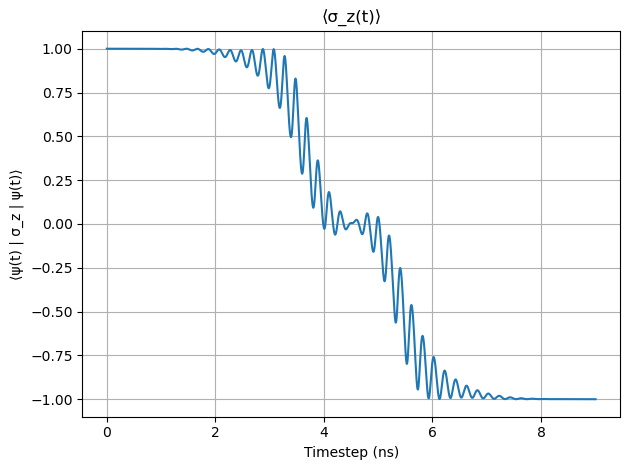

In [93]:
ts = 1:N
plot(dt*ts, szt)
xlabel("Timestep (ns)")
ylabel("⟨ψ(t) | σ_z | ψ(t)⟩")
title("⟨σ_z(t)⟩")
grid("on")
tight_layout()

# 3ns * 1.2 = pi

# Analyze Controls

In [94]:
function plot_control(controls, ts; label::String="u", index::Int = 1)    
    Ucv = map(cv -> cv[index], controls)
    Urv = map(cv -> real(cv), Ucv)
    Uiv = map(cv -> imag(cv), Ucv)
    Uav = map(cv -> norm(cv), Ucv)
    figure()
    plot(ts, Urv, label=string("Re[", label,"(t)]"))
    plot(ts, Uiv, label=string("Im[", label,"(t)]"))
    xlabel("Timestep (ns)")
    ylabel(string(label, "(t)"))
    legend()
    grid("on")
    tight_layout()
end

plot_control (generic function with 1 method)

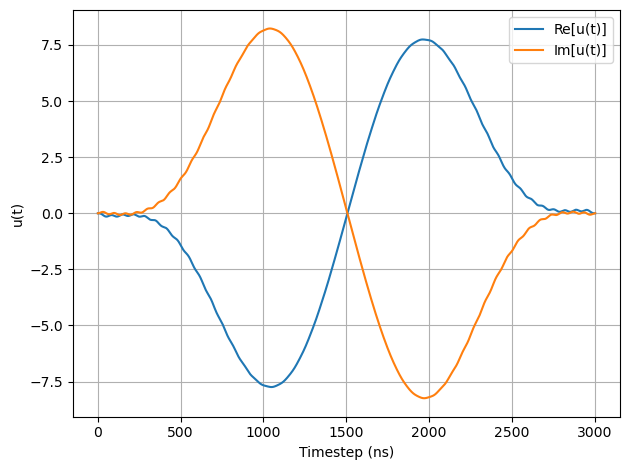

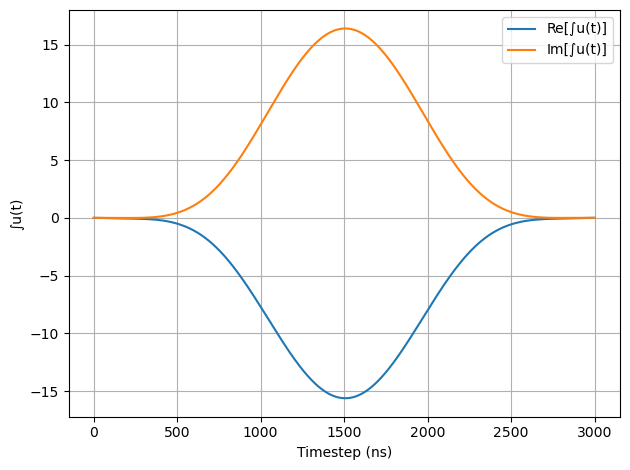

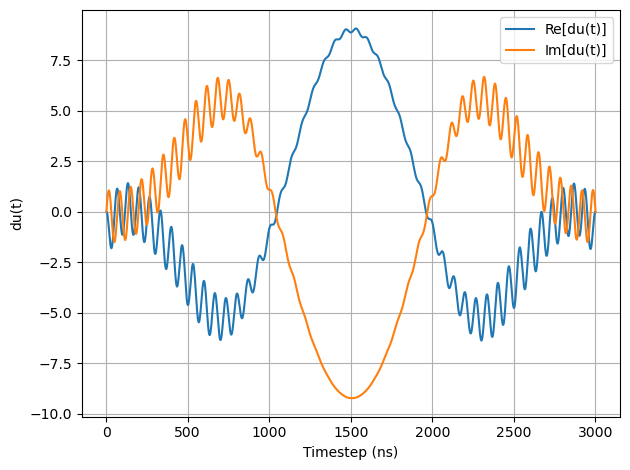

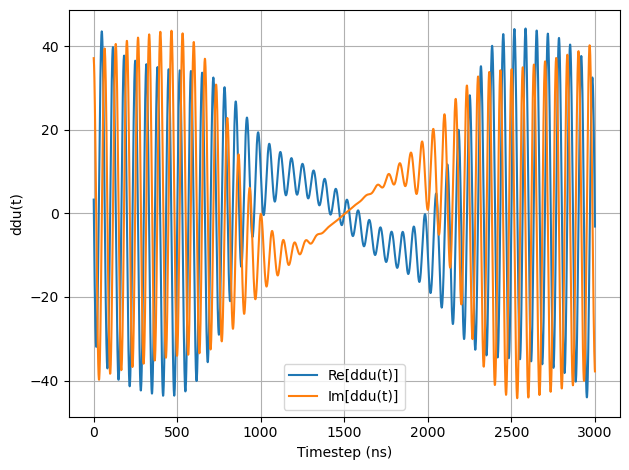

In [95]:
plot_control(Ucv, ts, label="u")
plot_control(iUcv, ts, label="∫u")
plot_control(dUcv, ts, label="du")
plot_control(ddUcv, ts[1:N-1], label="ddu")

In [39]:
# fft_plot(map(cv -> cv[1], Ucv), dt, tf)

In [41]:
# animate_bloch(Xqv[1:1:end], duration=0.03, save_all=true)

# References

[1] https://arxiv.org/pdf/1707.01060.pdf (quantum optics)

[2] https://github.com/alec-eickbusch/QOGS (quantum optimal gate synthesis)

[3] https://arxiv.org/pdf/2103.15716.pdf  (robotic quantum optimal control)

[4] https://journals.aps.org/prx/pdf/10.1103/PhysRevX.6.031006 (binomial code)